### Definition of an Idea:

Decision in which Borough in London to open a new venue.
London is a mega city with lots of cultures blended in it. This city seems to be full of opportunities. London is also a popular tourist destination. Many businessmen see great opportunities (as well as risks) in this city. The prices here are high, so it's very important to find the right place to open a new venue. 

- Is the competition in the area already too high?
- Who are the competitors?
- Is there enough relevant audience in the area?
- What are the most popular types of cousine in specific region?

The plan is to answer these and other questions by making the following steps:

1. Web scrape the names of the London Boroughs.
2. Analyse and choose which ones are good to work with. 
3. Obtain information about nearby venues, using Foursquare. 
4. Use k-means algorithm to cluster the venues. 
5. Visualise the results within the folium map. 
6. Evaluate and discuss the results. 
7. Derive the conclusions.

### The data we will work with:

We will scrape the wikipedia webpage: https://en.wikipedia.org/wiki/List_of_London_boroughs
This page contains the table with list of boroughs in London. 
The important information in the table is: Borugh name, Area, Population. 
Beautiful soup library will be used for this purpose.


#### Scrape with beautiful soap

In [ ]:
pip install BeautifulSoup4

In [ ]:
pip install geopy

In [3]:
# import the library we use to open URLs
import urllib.request
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup
import folium # map rendering library
import requests

import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors

In [53]:
# specify which URL we are going scrape
url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# parse the HTML from our URL into the BeautifulSoup python built-in parser
soup = BeautifulSoup(page, "html.parser")
print('The page title is: {}.'.format(soup.title.string))

The page title is: List of London boroughs - Wikipedia.


#### Scrape the table from the wikipedia page

In [54]:
wiki_table=soup.find('table', class_='wikitable sortable')

A=[] #Borough
B=[] #Inner
C=[] #Status
D=[] #Local Authority
E=[] #Political Control
F=[] #Headquarters
G=[] #Area
H=[] #Population

#read specific columns
for row in wiki_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==10:
        A.append(cells[0].find(text=True).rstrip())
        G.append(cells[6].find(text=True).rstrip())
        H.append(cells[7].find(text=True).rstrip())


#### Transform to pandas DF

In [55]:
import pandas as pd
#read the table into pandas df LondonBor
LondonBor=pd.DataFrame(A,columns=['Borough'])
LondonBor['Area']=G
LondonBor['Population']=H

print('The shape of the df is {}.'.format(LondonBor.shape))
LondonBor.head()


The shape of the df is (32, 3).


,Borough,Area,Population
0,Barking and Dagenham,13.93,"212,906"
1,Barnet,33.49,"395,896"
2,Bexley,23.38,"248,287"
3,Brent,16.70,"329,771"
4,Bromley,57.97,"332,336"


#### Get London Coordinates

In [56]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
lat1 = location.latitude
long1 = location.longitude
print('The coordinates of London are {}, {}.'.format(lat1, long1))

The coordinates of London are 51.5073219, -0.1276474.


#### Get the coordinates of the boroughs in London with Nominatim

In [57]:
Boroughs = A

latitude = []
longitude = []
for i in range(len(Boroughs)):
    address = str(Boroughs[i] + ', London, England')
    geolocator = Nominatim(user_agent="london_explorer")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    location = geolocator.geocode(address)
    try: 
        latitude.append(location.latitude)
        longitude.append(location.longitude)
    except:
        latitude.append("Not Found")
        longitude.append("Not Found")
    
print('Done Appending')

Done Appending


#### Append the coordinates to the df

In [58]:
LondonBor['Latitude'] = latitude
LondonBor['Longitude'] = longitude
LondonBor

,Borough,Area,Population,Latitude,Longitude
0,Barking and Dagenham,13.93,"212,906",51.554117,0.150504
1,Barnet,33.49,"395,896",51.653090,-0.200226
2,Bexley,23.38,"248,287",51.441679,0.150488
3,Brent,16.70,"329,771",51.563826,-0.275760
4,Bromley,57.97,"332,336",51.402805,0.014814
5,Camden,8.40,"270,029",51.542305,-0.139560
6,Croydon,33.41,"386,710",51.371305,-0.101957
7,Ealing,21.44,"341,806",51.512655,-0.305195
8,Enfield,31.74,"333,794",51.652085,-0.081018
9,Greenwich,18.28,"287,942",51.482084,-0.004542


#### Let's creat a map of London with its boroughs

In [59]:
London_map = folium.Map(location=[lat1, long1], zoom_start=10)

# add markers to our map
for lat, lng, borough in zip(LondonBor['Latitude'], LondonBor['Longitude'], LondonBor['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(London_map)  
    
London_map

#### Foursquare credentials

In [12]:
LIMIT = 200
CLIENT_ID = 'UAT3YI3TIGW4PMH0KMUKYXWTSCFKSOYVB4MSE20HOK0QJHLO' # your Foursquare ID
CLIENT_SECRET = '5FIYZ04CKGQZVN2OFEWVFKU2TH2BQP1ZQ3ZFCW5XB4PCRAAL' # your Foursquare Secret
VERSION = '20201201' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UAT3YI3TIGW4PMH0KMUKYXWTSCFKSOYVB4MSE20HOK0QJHLO
CLIENT_SECRET:5FIYZ04CKGQZVN2OFEWVFKU2TH2BQP1ZQ3ZFCW5XB4PCRAAL


#### Get venius in the radius of 1500 meters around the coordinates of each Borough


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
London_venues = getNearbyVenues(names=LondonBor['Borough'],
                                   latitudes=LondonBor['Latitude'],
                                   longitudes=LondonBor['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [61]:
print('The shape of london venue is: {}'.format(London_venues.shape))
London_venues.head(10)

The shape of london venue is: (2404, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.554117,0.150504,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.554117,0.150504,Lara Grill,51.562445,0.147178,Turkish Restaurant
2,Barking and Dagenham,51.554117,0.150504,Iceland,51.560578,0.147685,Grocery Store
3,Barking and Dagenham,51.554117,0.150504,wilko,51.541474,0.148855,Furniture / Home Store
4,Barking and Dagenham,51.554117,0.150504,BP,51.549951,0.161963,Gas Station
5,Barking and Dagenham,51.554117,0.150504,Asda,51.565770,0.143393,Supermarket
6,Barking and Dagenham,51.554117,0.150504,B&M Store,51.565287,0.143793,Discount Store
7,Barking and Dagenham,51.554117,0.150504,Lidl,51.542819,0.148625,Supermarket
8,Barking and Dagenham,51.554117,0.150504,Shell,51.560415,0.148364,Gas Station
9,Barking and Dagenham,51.554117,0.150504,The Pipe Major,51.545795,0.165834,Restaurant


In [43]:
# List of unique venue categories
# London_venues['Venue Category'].unique()

In [62]:
print('There are {} uniques categories.'.format(len(London_venues['Venue Category'].unique())))

There are 246 uniques categories.


#### We will concentrate on cousine venues

In [63]:
London_cousine = London_venues[London_venues['Venue Category'].str.contains("Restaurant") | London_venues['Venue Category'].str.contains("Food") | 
                              London_venues['Venue Category'].str.contains("Cafe") | London_venues['Venue Category'].str.contains("Cousine") |
                              London_venues['Venue Category'].str.contains("Sandwich") | London_venues['Venue Category'].str.contains("Snack")]

print('The shape of london cousine is: {}'.format(London_cousine.shape))
print('There are {} uniques categories.'.format(len(London_cousine['Venue Category'].unique())))

The shape of london cousine is: (541, 7)
There are 59 uniques categories.


#### One hot encoding

In [64]:
London_onehot = pd.get_dummies(London_cousine[['Venue Category']], prefix="", prefix_sep="")

# add borough column to onehot df
London_onehot['Borough'] = London_cousine['Borough'] 

# move borough column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head(10)

,Borough,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Doner Restaurant,...,Sri Lankan Restaurant,Street Food Gathering,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,Barking and Dagenham,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
32,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,Barnet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
London_group = London_onehot.groupby('Borough').mean().reset_index()
London_group

,Borough,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Doner Restaurant,...,Sri Lankan Restaurant,Street Food Gathering,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Barking and Dagenham,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
1,Barnet,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bexley,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Brent,0.00,0.090909,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bromley,0.00,0.100000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
5,Camden,0.00,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.037037
6,Croydon,0.00,0.000000,0.000000,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,...,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000
7,Ealing,0.00,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.032258,...,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.064516
8,Enfield,0.00,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000
9,Greenwich,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.071429,0.071429,0.071429,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000


#### Let's print each borough along with the top 5 most common cousine-venues

In [66]:
num_top_cousine = 5

for hood in London_group['Borough']:
    print("----"+hood+"----")
    temp = London_group[London_group['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_cousine))
    print('\n')

----Barking and Dagenham----
                venue  freq
0  Turkish Restaurant  0.33
1  Chinese Restaurant  0.33
2          Restaurant  0.33
3   Afghan Restaurant  0.00
4  Seafood Restaurant  0.00


----Barnet----
                  venue  freq
0  Fast Food Restaurant  0.29
1    Seafood Restaurant  0.14
2    Italian Restaurant  0.14
3     Indian Restaurant  0.14
4            Restaurant  0.14


----Bexley----
                  venue  freq
0  Fast Food Restaurant  0.50
1    Italian Restaurant  0.25
2      Greek Restaurant  0.25
3     Afghan Restaurant  0.00
4    Seafood Restaurant  0.00


----Brent----
                  venue  freq
0        Sandwich Place  0.18
1     Indian Restaurant  0.18
2   American Restaurant  0.09
3            Food Court  0.09
4  Fast Food Restaurant  0.09


----Bromley----
                  venue  freq
0     Indian Restaurant   0.3
1   American Restaurant   0.1
2      Asian Restaurant   0.1
3    Turkish Restaurant   0.1
4  Fast Food Restaurant   0.1


----Camden---

#### First, let's write a function to sort the venues in descending order.

In [67]:
def return_most_common_venues(row, num_top_cousine):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cousine]

Now let's create the new dataframe and display the top 5 venues for each borough.


In [68]:
#Creating a new dataframe and displaying the top 5 restaurants based on occurance and cuisine for each borough
num_top_cousine = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top cousine
columns = ['Borough']
for ind in np.arange(num_top_cousine):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_cousine_sorted = pd.DataFrame(columns=columns)
borough_cousine_sorted['Borough'] = London_group['Borough']


for ind in np.arange(London_group.shape[0]):
    borough_cousine_sorted.iloc[ind, 1:] = return_most_common_venues(London_group.iloc[ind, :], num_top_cousine)

borough_cousine_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Barking and Dagenham,Restaurant,Turkish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant
1,Barnet,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Indian Restaurant,Restaurant
2,Bexley,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Vietnamese Restaurant,Indian Restaurant
3,Brent,Indian Restaurant,Sandwich Place,American Restaurant,Food Court,Fast Food Restaurant
4,Bromley,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Sushi Restaurant


### Custering Boroughs using K-means

#### Find the best _K_ using The Silhouette Method

The silhouette value measures how similar a point is to its own cluster compared to other clusters.

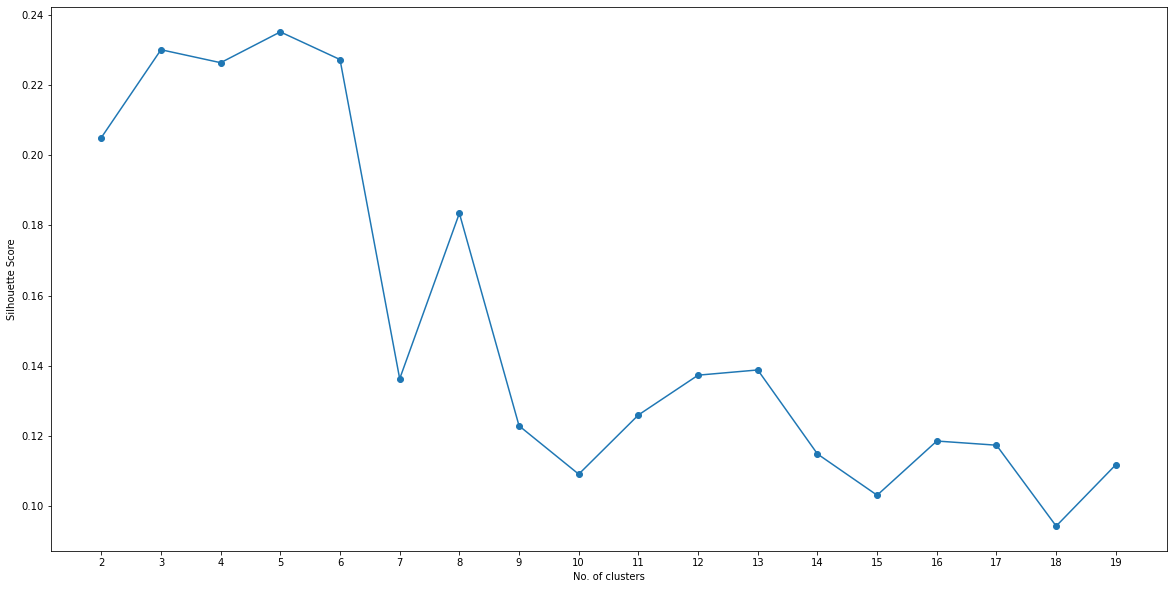

In [69]:
London_k_testing = London_group.drop('Borough', 1)

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = London_k_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Choose The optimum value

In [70]:
# we'll choose 5 clusters for our goal
best = 5

In [71]:
# set number of clusters
kclusters = best

London_grouped_clustering = London_group.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 3, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

In [72]:
# add clustering labels
borough_cousine_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_final = London_cousine

# merge london final with borough cousine to add latitude/longitude for each borough
London_final = London_final.join(borough_cousine_sorted.set_index('Borough'), on='Borough')
London_final.fillna(0)
London_final.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Barking and Dagenham,51.554117,0.150504,Lara Grill,51.562445,0.147178,Turkish Restaurant,2,Restaurant,Turkish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant
9,Barking and Dagenham,51.554117,0.150504,The Pipe Major,51.545795,0.165834,Restaurant,2,Restaurant,Turkish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant
19,Barking and Dagenham,51.554117,0.150504,New China Gold,51.561269,0.141839,Chinese Restaurant,2,Restaurant,Turkish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant
32,Barnet,51.653090,-0.200226,Spizzico,51.656600,-0.201802,Italian Restaurant,1,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Indian Restaurant,Restaurant
37,Barnet,51.653090,-0.200226,Dudley's Pancake House,51.652965,-0.199625,Restaurant,1,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Indian Restaurant,Restaurant


#### Count number of values for each cluster

In [73]:
London_final['Cluster Labels'].value_counts()


1    423
2     55
0     55
4      4
3      4
Name: Cluster Labels, dtype: int64

#### Creating map for each cluster for better visualization

In [74]:
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
count = 0 
for lat, lon, poi, cluster, vc in zip(London_final['Venue Latitude'], London_final['Venue Longitude'], London_final['Venue'], London_final['Cluster Labels'], London_final['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Analyzing each cluster on its own

#### Cluster #1

In [38]:
c1 = London_final.loc[London_final['Cluster Labels'] == 0, London_final.columns[[0]+list(range(8, London_final.shape[1]))]]
c1.drop_duplicates()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
181,Bromley,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Sushi Restaurant
536,Enfield,Fast Food Restaurant,Indian Restaurant,Sandwich Place,Turkish Restaurant,American Restaurant
999,Harrow,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Thai Restaurant,Asian Restaurant
1125,Hillingdon,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Vietnamese Restaurant,Italian Restaurant
1139,Hounslow,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Restaurant,Portuguese Restaurant
1800,Newham,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Asian Restaurant,Italian Restaurant


In [39]:
c1_table = London_final.loc[London_final['Cluster Labels'] == 0, London_final.columns[[0]+[3]+[4]+[5]+list(range(8, London_final.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Borough'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Cluster #2

In [40]:
c2 = London_final.loc[London_final['Cluster Labels'] == 1, London_final.columns[[0]+list(range(8, London_final.shape[1]))]]
c2.drop_duplicates()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
32,Barnet,Fast Food Restaurant,Sandwich Place,Seafood Restaurant,Indian Restaurant,Restaurant
84,Brent,Indian Restaurant,Sandwich Place,American Restaurant,Food Court,Fast Food Restaurant
235,Camden,Italian Restaurant,Middle Eastern Restaurant,French Restaurant,Falafel Restaurant,Greek Restaurant
334,Croydon,Indian Restaurant,Mediterranean Restaurant,Italian Restaurant,Portuguese Restaurant,Sushi Restaurant
433,Ealing,Italian Restaurant,Vietnamese Restaurant,Indian Restaurant,Sushi Restaurant,Persian Restaurant
603,Greenwich,Indian Restaurant,Turkish Restaurant,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant
706,Hackney,Vietnamese Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant
801,Hammersmith and Fulham,Thai Restaurant,Italian Restaurant,French Restaurant,Japanese Restaurant,Turkish Restaurant
1026,Havering,French Restaurant,Falafel Restaurant,Italian Restaurant,Greek Restaurant,Middle Eastern Restaurant
1198,Islington,Mediterranean Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant


In [41]:
c2_table = London_final.loc[London_final['Cluster Labels'] == 1, London_final.columns[[0]+[3]+[4]+[5]+list(range(8, London_final.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c2_table['Venue Latitude'], c2_table['Venue Longitude'], c2_table['Venue'], c2_table['Borough'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Cluster #3

In [42]:
c3 = London_final.loc[London_final['Cluster Labels'] == 2, London_final.columns[[0]+list(range(8, London_final.shape[1]))]]
c3.drop_duplicates()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Barking and Dagenham,Restaurant,Turkish Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indian Restaurant
898,Haringey,Turkish Restaurant,Mediterranean Restaurant,Tapas Restaurant,Indian Restaurant,French Restaurant
2084,Tower Hamlets,Turkish Restaurant,Italian Restaurant,Chinese Restaurant,Food Truck,Middle Eastern Restaurant
2172,Waltham Forest,Turkish Restaurant,Vegetarian / Vegan Restaurant,Portuguese Restaurant,Vietnamese Restaurant,Fast Food Restaurant


In [43]:
c3_table = London_final.loc[London_final['Cluster Labels'] == 2, London_final.columns[[0]+[3]+[4]+[5]+list(range(8, London_final.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c3_table['Venue Latitude'], c3_table['Venue Longitude'], c3_table['Venue'], c3_table['Borough'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Cluster #4

In [44]:
c4 = London_final.loc[London_final['Cluster Labels'] == 3, London_final.columns[[0]+list(range(8, London_final.shape[1]))]]
c4.drop_duplicates()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
67,Bexley,Fast Food Restaurant,Italian Restaurant,Greek Restaurant,Vietnamese Restaurant,Indian Restaurant


In [48]:
c4_table = London_final.loc[London_final['Cluster Labels'] == 3, London_final.columns[[0]+[3]+[4]+[5]+list(range(8, London_final.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c4_table['Venue Latitude'], c4_table['Venue Longitude'], c4_table['Venue'], c4_table['Borough'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

In [46]:
c5 = London_final.loc[London_final['Cluster Labels'] == 4, London_final.columns[[0]+list(range(8, London_final.shape[1]))]]
c5.drop_duplicates()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1884,Richmond upon Thames,Mediterranean Restaurant,German Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant


In [49]:
c5_table = London_final.loc[London_final['Cluster Labels'] == 4, London_final.columns[[0]+[3]+[4]+[5]+list(range(8, London_final.shape[1]))]]
# create map
map_clusters = folium.Map(location=[lat1, long1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c5_table['Venue Latitude'], c5_table['Venue Longitude'], c5_table['Venue'], c5_table['Borough'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='brown',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Results table

| Cluster | 1st most common | 2nd most common | 
| :-: | :-: | :-: |
| 1 | Indian | Sandwich Place | 
| 2 | Italian | Indian |
| 3 | Turkish | Chinese |


#### Discussion
Now that we have clusters for different boroughs in London, we can try and get decisions if we will open a new restaurant, in which borough, what type of food, etc. We can open a popular cuisine or we can do the other way around. 
It now depends on the business model we prefer.


#### Conclusion
The analysis can be widened to other fields like: crime rate, kind of population in the specific borough etc. The number of clusters we received was eventually low. It would be a better analysis if we also had neighborhoods, and it would allow us to divide the information in more accurate way. Yet we can still see specific clustering according to the kind of restaurants.